# Weapon Accuracy

## Setting Up

In [1]:
import pandas as pd
import calendar

weapon_stats = pd.read_csv("datasets/weapon_stats.csv")
ammo_stats = pd.read_csv("datasets/ammo_stats.csv")
weapon_firemodes = pd.read_csv("datasets/weapon_firemodes.csv")

# Exploring Data

In [2]:
weapon_stats.head()

,weapon,grip
0,pistol,1
1,rifle,2
2,heavy_cannon,2
3,auto_cannon,2
4,rocket_launcher,2


In [3]:
ammo_stats.head()

,weapon,ammo,damage,damage_type,capacity
0,pistol,pistol_clip,26,armor_piercing,12.0
1,rifle,rifle_clip,30,armor_piercing,20.0
2,heavy_cannon,heavy_cannon_ap,56,armor_piercing,6.0
3,heavy_cannon,heavy_cannon_he,52,high_explosive,6.0
4,heavy_cannon,heavy_cannon_inc,60,incendiary,6.0


In [4]:
weapon_firemodes.head()

,weapon,fire_mode,time_units,accuracy
0,pistol,snapshot,18,60
1,pistol,aimed,30,78
2,rifle,auto,35,35
3,rifle,snapshot,25,60
4,rifle,aimed,80,110


# Data Merge

In [5]:
weapon_attacks = weapon_stats.merge(ammo_stats, on="weapon")
weapon_attacks = weapon_attacks.merge(weapon_firemodes, on="weapon")
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy
0,pistol,1,pistol_clip,26,armor_piercing,12.0,snapshot,18,60
1,pistol,1,pistol_clip,26,armor_piercing,12.0,aimed,30,78
2,rifle,2,rifle_clip,30,armor_piercing,20.0,auto,35,35
3,rifle,2,rifle_clip,30,armor_piercing,20.0,snapshot,25,60
4,rifle,2,rifle_clip,30,armor_piercing,20.0,aimed,80,110


# Accuracy Range

Soldiers start with an Accuracy value between 40 and 70. But the attribute may go up to 120. So we are going to prepare a set moving between 40 and 120.

In [6]:
data = [40, 50, 60, 80, 90, 100, 110, 120]
accuracy_range = pd.DataFrame(data, columns = ["soldier_accuracy"])
accuracy_range

,soldier_accuracy
0,40
1,50
2,60
3,80
4,90
5,100
6,110
7,120


## Merging With Weapons

In [7]:
weapon_attacks_proficiency = weapon_attacks
weapon_attacks_proficiency = weapon_attacks_proficiency.append([weapon_attacks_proficiency] * (len(accuracy_range.index)-1), ignore_index=True)
weapon_attacks_proficiency["key"] = weapon_attacks_proficiency.groupby(["weapon", "ammo", "fire_mode"]).cumcount()

weapon_attacks_proficiency = pd.merge(weapon_attacks_proficiency, accuracy_range, left_on="key", right_index=True, how="left", sort=False)
weapon_attacks_proficiency = weapon_attacks_proficiency.drop(columns=["key"])
weapon_attacks_proficiency

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,soldier_accuracy
0,pistol,1,pistol_clip,26,armor_piercing,12.0,snapshot,18,60,40
1,pistol,1,pistol_clip,26,armor_piercing,12.0,aimed,30,78,40
2,rifle,2,rifle_clip,30,armor_piercing,20.0,auto,35,35,40
3,rifle,2,rifle_clip,30,armor_piercing,20.0,snapshot,25,60,40
4,rifle,2,rifle_clip,30,armor_piercing,20.0,aimed,80,110,40
...,...,...,...,...,...,...,...,...,...,...
475,laser_turret,2,laser_beam,110,laser,255.0,snapshot,75,85,120
476,laser_turret,2,laser_beam,110,laser,255.0,aimed,33,50,120
477,plasma_turret,2,plasma,110,plasma,255.0,snapshot,30,85,120
478,plasma_turret,2,plasma,110,plasma,255.0,aimed,60,100,120


## Final Accuracy

For our need the accuracy formula is just the weapon accuracy multiplied by the soldier accuracy.

In [8]:
weapon_attacks_proficiency["final_accuracy"] = weapon_attacks_proficiency.apply(lambda x: x["accuracy"] * x["soldier_accuracy"] / 10000, axis=1)
weapon_attacks_proficiency

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,soldier_accuracy,final_accuracy
0,pistol,1,pistol_clip,26,armor_piercing,12.0,snapshot,18,60,40,0.240
1,pistol,1,pistol_clip,26,armor_piercing,12.0,aimed,30,78,40,0.312
2,rifle,2,rifle_clip,30,armor_piercing,20.0,auto,35,35,40,0.140
3,rifle,2,rifle_clip,30,armor_piercing,20.0,snapshot,25,60,40,0.240
4,rifle,2,rifle_clip,30,armor_piercing,20.0,aimed,80,110,40,0.440
...,...,...,...,...,...,...,...,...,...,...,...
475,laser_turret,2,laser_beam,110,laser,255.0,snapshot,75,85,120,1.020
476,laser_turret,2,laser_beam,110,laser,255.0,aimed,33,50,120,0.600
477,plasma_turret,2,plasma,110,plasma,255.0,snapshot,30,85,120,1.020
478,plasma_turret,2,plasma,110,plasma,255.0,aimed,60,100,120,1.200


# Weapon Accuracies

In [9]:
weapon_proficiency_development = weapon_attacks_proficiency[["weapon", "fire_mode", "soldier_accuracy", "final_accuracy"]]
weapon_proficiency_development = weapon_proficiency_development.groupby(["weapon", "soldier_accuracy"]).mean()
weapon_proficiency_development = weapon_proficiency_development.sort_values(by=["weapon"])
weapon_proficiency_development

final_accuracy
weapon        soldier_accuracy                
alien_grenade 40                         0.260
              50                         0.325
              60                         0.390
              80                         0.520
              90                         0.585
...                                        ...
stun_rod      110                        1.100
              50                         0.500
              40                         0.400
              60                         0.600
              120                        1.200

[184 rows x 1 columns]

## Kinetic Weapons

In [10]:
weapon_proficiency_development.loc[ ["pistol"] ]

final_accuracy
weapon soldier_accuracy                
pistol 40                         0.276
       50                         0.345
       60                         0.414
       80                         0.552
       90                         0.621
       100                        0.690
       110                        0.759
       120                        0.828

Text(0, 0.5, 'Final accuracy')

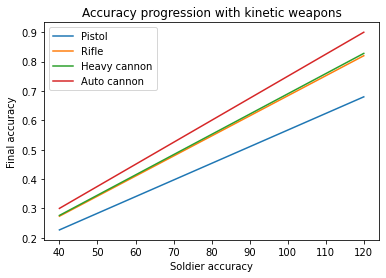

In [11]:
weapon_proficiency_development_kinetic = weapon_proficiency_development.loc[ ["pistol", "rifle", "heavy_cannon", "auto_cannon"] ]
weapon_proficiency_development_kinetic = weapon_proficiency_development_kinetic.sort_values(by=["final_accuracy"])
weapon_proficiency_development_kinetic = weapon_proficiency_development_kinetic.unstack(level=0)
ax = weapon_proficiency_development_kinetic.plot(title="Accuracy progression with kinetic weapons")
ax.legend(["Pistol", "Rifle", "Heavy cannon", "Auto cannon"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

## Melee

Text(0, 0.5, 'Final accuracy')

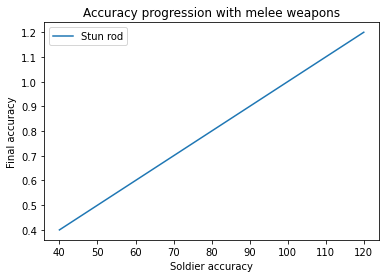

In [12]:
weapon_proficiency_development_melee = weapon_proficiency_development.loc[ ["stun_rod"] ]
weapon_proficiency_development_melee = weapon_proficiency_development_melee.sort_values(by=["final_accuracy"])
weapon_proficiency_development_melee = weapon_proficiency_development_melee.unstack(level=0)
ax = weapon_proficiency_development_melee.plot(title="Accuracy progression with melee weapons")
ax.legend(["Stun rod"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

## Explosive

Text(0, 0.5, 'Final accuracy')

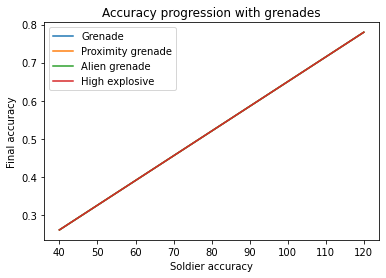

In [13]:
weapon_proficiency_development_grenade = weapon_proficiency_development.loc[ ["grenade", "proximity_grenade", "alien_grenade", "high_explosive"] ]
weapon_proficiency_development_grenade = weapon_proficiency_development_grenade.sort_values(by=["final_accuracy"])
weapon_proficiency_development_grenade = weapon_proficiency_development_grenade.unstack(level=0)
ax = weapon_proficiency_development_grenade.plot(title="Accuracy progression with grenades")
ax.legend(["Grenade", "Proximity grenade", "Alien grenade", "High explosive"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

Text(0, 0.5, 'Final accuracy')

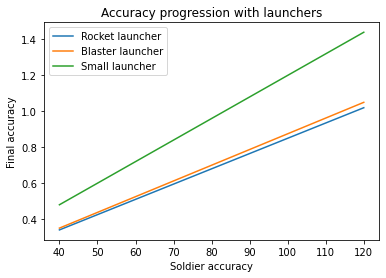

In [14]:
weapon_proficiency_development_launcher = weapon_proficiency_development.loc[ ["rocket_launcher", "blaster_launcher", "small_launcher"] ]
weapon_proficiency_development_launcher = weapon_proficiency_development_launcher.sort_values(by=["final_accuracy"])
weapon_proficiency_development_launcher = weapon_proficiency_development_launcher.unstack(level=0)
ax = weapon_proficiency_development_launcher.plot(title="Accuracy progression with launchers")
ax.legend(["Rocket launcher", "Blaster launcher", "Small launcher"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

## Laser

Text(0, 0.5, 'Final accuracy')

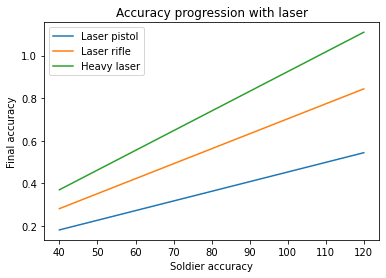

In [15]:
weapon_proficiency_development_laser = weapon_proficiency_development.loc[ ["laser_pistol", "laser_rifle", "heavy_laser"] ]
weapon_proficiency_development_laser = weapon_proficiency_development_laser.sort_values(by=["final_accuracy"])
weapon_proficiency_development_laser = weapon_proficiency_development_laser.unstack(level=0)
ax = weapon_proficiency_development_laser.plot(title="Accuracy progression with laser")
ax.legend(["Laser pistol", "Laser rifle", "Heavy laser"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

## Plasma

Text(0, 0.5, 'Final accuracy')

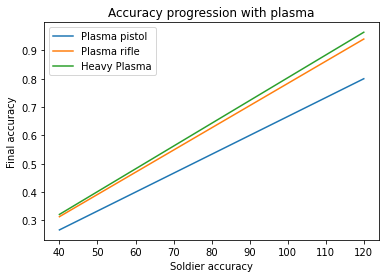

In [16]:
weapon_proficiency_development_plasma = weapon_proficiency_development.loc[ ["plasma_pistol", "plasma_rifle", "heavy_plasma"] ]
weapon_proficiency_development_plasma = weapon_proficiency_development_plasma.sort_values(by=["final_accuracy"])
weapon_proficiency_development_plasma = weapon_proficiency_development_plasma.unstack(level=0)
ax = weapon_proficiency_development_plasma.plot(title="Accuracy progression with plasma")
ax.legend(["Plasma pistol", "Plasma rifle", "Heavy Plasma"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

## Tank

Tanks don't increase skills. But the calculations are included.

Text(0, 0.5, 'Final accuracy')

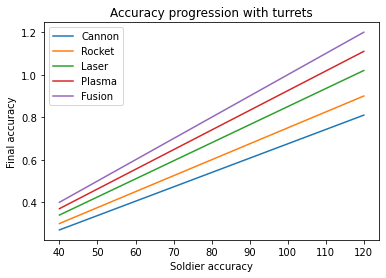

In [17]:
weapon_proficiency_development_turret = weapon_proficiency_development.loc[ ["cannon_turret", "rocket_turret", "laser_turret", "plasma_turret", "fusion_turret"] ]
weapon_proficiency_development_turret = weapon_proficiency_development_turret.sort_values(by=["final_accuracy"])
weapon_proficiency_development_turret = weapon_proficiency_development_turret.unstack(level=0)
ax = weapon_proficiency_development_turret.plot(title="Accuracy progression with turrets")
ax.legend(["Cannon", "Rocket", "Laser", "Plasma", "Fusion"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")